# Data Preprocessing and Exploratory Data Analysis

When working with any new dataset, it's a good idea to try to explore it to understand the values in it and any obvious patterns. 

Here, we will also process the dataset to make it usable for machine learning. 

To begin, let's import some standard data manipulation and visualisation libraries. 

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Unlike a lot of our previous notebooks, we're going to work with the raw titanic dataset so we can explore the ways in which we can prepare the notebook. 

We will undertake some additional cleaning, so the final result will not look exactly like the dataset we are used to from other examples.

In [20]:
try:
    data = pd.read_csv("data/raw_data.csv")

except FileNotFoundError:

    # Download raw data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/train.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'raw_data.csv', index=False)

## Initial exploration

Let's first check how many values we have.

In [21]:
len(data)

891

View the first five rows.

In [22]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check the ranges and distributions of the values.

In [23]:
data.describe().round(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


We can use the following code to quickly view histograms for every column in the dataset.

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

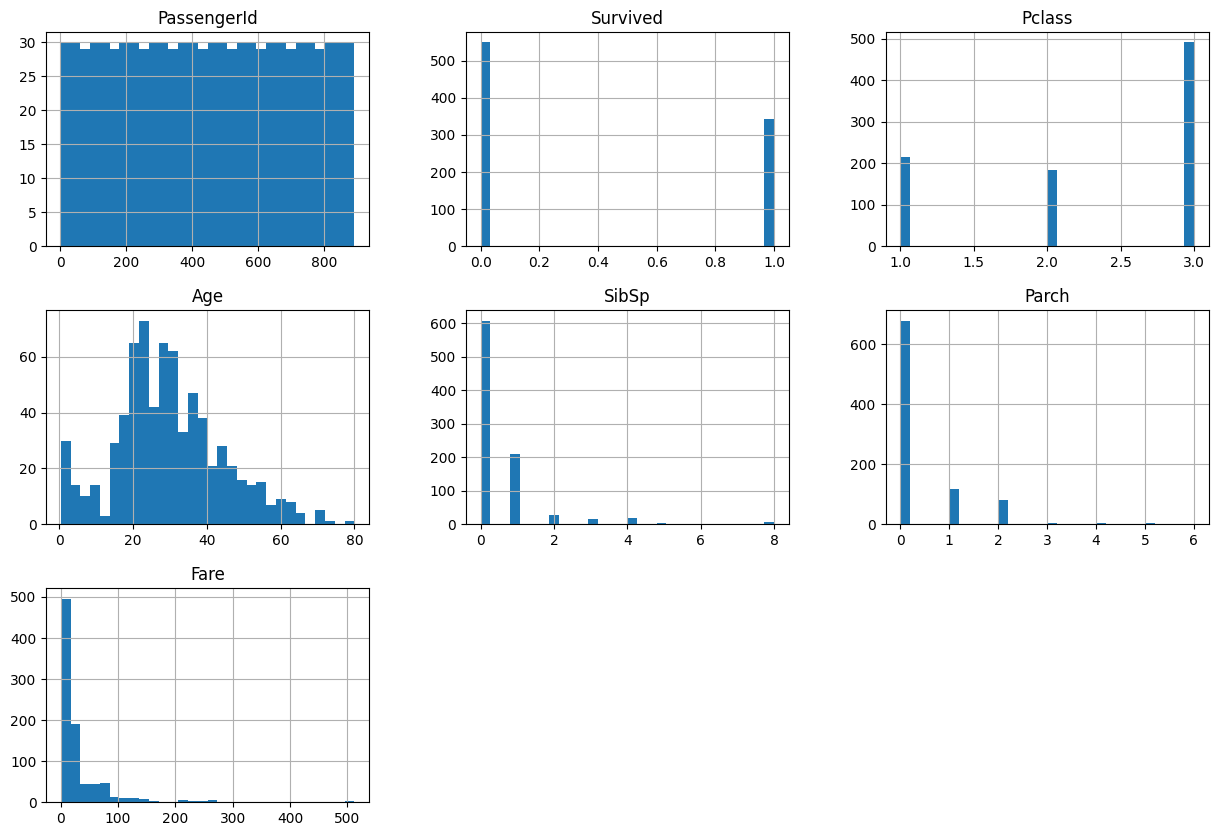

In [24]:
data.hist(bins=30, figsize=(15, 10))

Get a full list of column names.

In [25]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Check for missing data 

This snippet gives us a quick overview of which columns have missing data and how much is missing. 

In [26]:
pd.DataFrame(
    data.isna().mean().round(4),
    columns=["Percentage of Values Missing"]
    )

,Percentage of Values Missing
PassengerId,0.0000
Survived,0.0000
Pclass,0.0000
Name,0.0000
Sex,0.0000
Age,0.1987
SibSp,0.0000
Parch,0.0000
Ticket,0.0000
Fare,0.0000


# Making Column Contents Clearer

In some cases, the contents of the column isn't very intuitive and is going to result in us spending a lot of time looking up what the values mean.

For example, the embarked column isn't very clear.

In [27]:
data.Embarked

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

Let's first check how many distinct values we have.

When we grab a single column from a pandas dataframe like `data['Embarked']` or `data.Embarked` this returns a pandas *series*. The series object has a method called `unique()` we can use.

In [28]:
data.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

Let's now create a lookup dictionary for these values.

In [29]:
embarked_lookup = {
    'S': 'Southampton',
    'C':  'Cherbourg',
    'Q': 'Queenstown'
}

Finally, let's replace these values in the dataframe, overwriting our original embarked column. 

In [30]:
data['Embarked'] = data['Embarked'].apply(lambda row_value: embarked_lookup.get(row_value))

We can then view the counts for this column.

In [31]:
data['Embarked'].value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: Embarked, dtype: int64

# One-hot encoding

Machine learning models - with a few exceptions like catboost - generally can't cope with columns where the columns refer to a series of possible categories. 

We have to convert these to a wider format - each category becomes its own column, and will have a 1 in the row where the column name matches the original category, and a 0 in all other columns.

While there is an sklearn method for this, pandas has a nice method that's a bit more intuitive, so we'll use that here. 

In [32]:
# Create a one-hot encoded representation of the data
one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked').astype('int')

# Drop the column as it is now encoded
data = data.drop('Embarked', axis = 1)

# Join the encoded df
# As we have not specified, in this case it will join on the only common
# element of the two dataframes - the index
data = data.join(one_hot)

data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,1,0,0


# Dichotomous Columns

When there are only two values (a 'dichotomous' column), we still need to convert this to a different representation for machine learning. 

Rather than one-hot encoding, it makes more sense to turn it into a column where one value is represented by 0, and the other value is represented by 1. For example, here we have a Sex column that only codes sex as 'male' or 'female' - we can choose one of these to be 0, and the other to be 1. 

To do this, we could create a lookup (like we did for Embarked), or we could use the simple code below.

In [33]:
data['Sex'].replace('male', 1, inplace=True)
data['Sex'].replace('female', 0, inplace=True)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1


We could now make this column clearer to interpret without a data dictionary by changing its name. 

In [34]:
data = data.rename(columns={'Sex': 'IsMale'})
data.head()

,PassengerId,Survived,Pclass,Name,IsMale,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1


# Imputation

If we were using a model that requires missing values to be dealt with, or we wanted more control over how missing values are treated, we could use an imputation method. 

In this example we're just using XGBoost, which can handle missing values natively, so we will skip this step for now. 

You can look at the notebook `missing_data_imputation.ipynb` to find out more about imputation methods.

# Exploratory Data Analysis (EDA)

Before we get too far into modelling this, it's a good idea to develop a bit of an understanding of our columns and the simple patterns in our dataset.

## Exploring Simple Patterns

Let's first just look at average values for each column depending on whether people survived or not.

Think about how you'd interpret this for binary columns like 'IsMale' and 'Embarked_Cherbourg'. 

In [35]:
data.groupby('Survived').mean(numeric_only=True).round(4)

,PassengerId,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
Survived,,,,,,,,,,
0,447.0164,2.5319,0.8525,30.6262,0.5537,0.3297,22.1179,0.1366,0.0856,0.7778
1,444.3684,1.9503,0.3187,28.3437,0.4737,0.4649,48.3954,0.2719,0.0877,0.6345


We can visualise the differences in distributions across these groups using the pandas boxplot method.

We end up with one plot per column, with two boxplots for each column - one for those who died on the left of each plot, and one for those who survived on the right.

They're not that informative where we have binary columns, unfortunately! 

array([[<Axes: title={'center': 'Age'}, xlabel='[Survived]'>,
        <Axes: title={'center': 'Embarked_Cherbourg'}, xlabel='[Survived]'>,
        <Axes: title={'center': 'Embarked_Queenstown'}, xlabel='[Survived]'>],
       [<Axes: title={'center': 'Embarked_Southampton'}, xlabel='[Survived]'>,
        <Axes: title={'center': 'Fare'}, xlabel='[Survived]'>,
        <Axes: title={'center': 'IsMale'}, xlabel='[Survived]'>],
       [<Axes: title={'center': 'Parch'}, xlabel='[Survived]'>,
        <Axes: title={'center': 'PassengerId'}, xlabel='[Survived]'>,
        <Axes: title={'center': 'Pclass'}, xlabel='[Survived]'>],
       [<Axes: title={'center': 'SibSp'}, xlabel='[Survived]'>, <Axes: >,
        <Axes: >]], dtype=object)

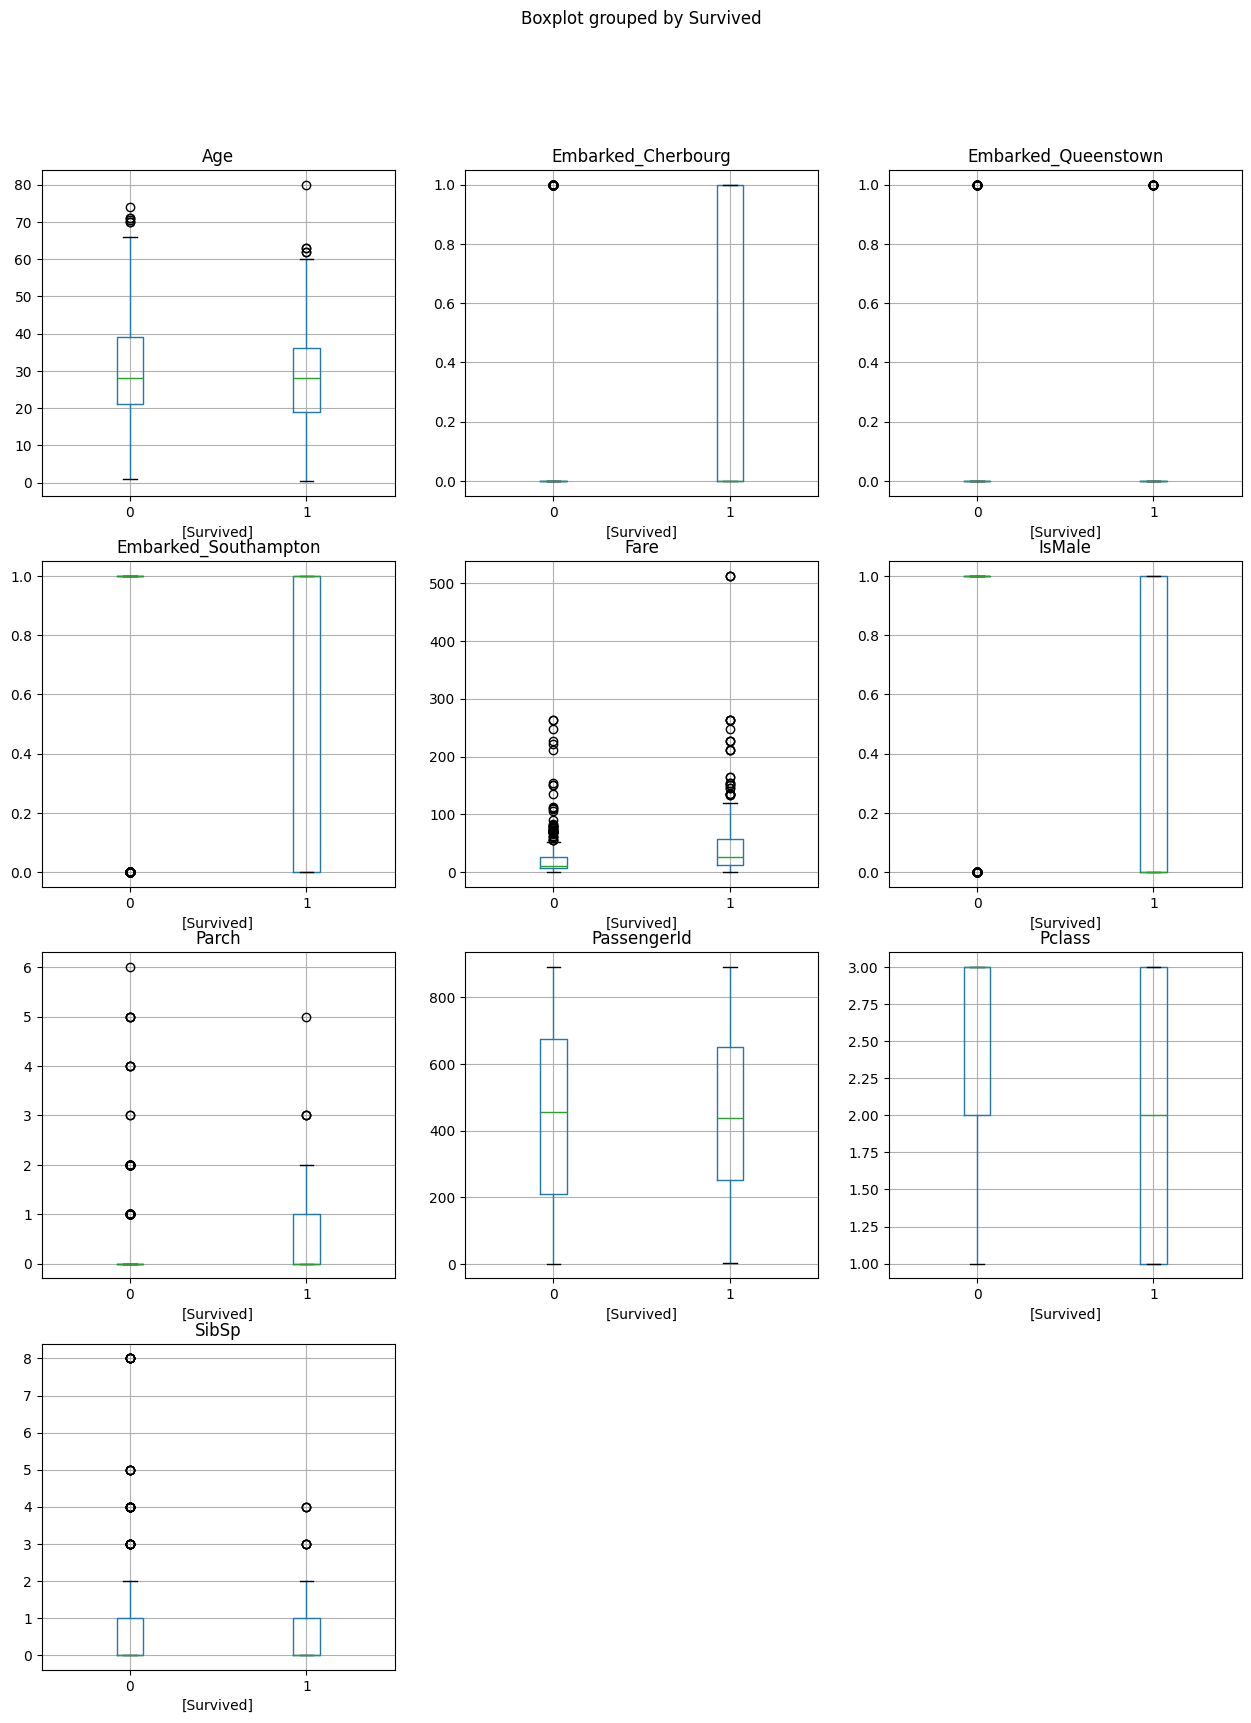

In [36]:
data.boxplot(
    by='Survived', # Column to segregate by
    figsize = (15, 20), # adjust overall size of output figure
    sharey=False, # Allows each variable to be plotted on its own scale
    sharex=False # Not strictly necessary but a nice way to get the 0/1 labels on every plot
    )

We can't use the pandas .hist() column with the 'by' parameter as it plots every column on the same plot! So we'll create the plot we want by running the hist command on two separate filtered dataframes - one containing those who survived and one containing those who didn't.  

array([<Axes: title={'center': 'PassengerId'}>,
       <Axes: title={'center': 'Survived'}>,
       <Axes: title={'center': 'Pclass'}>,
       <Axes: title={'center': 'IsMale'}>,
       <Axes: title={'center': 'Age'}>, <Axes: title={'center': 'SibSp'}>,
       <Axes: title={'center': 'Parch'}>,
       <Axes: title={'center': 'Fare'}>,
       <Axes: title={'center': 'Embarked_Cherbourg'}>,
       <Axes: title={'center': 'Embarked_Queenstown'}>,
       <Axes: title={'center': 'Embarked_Southampton'}>], dtype=object)

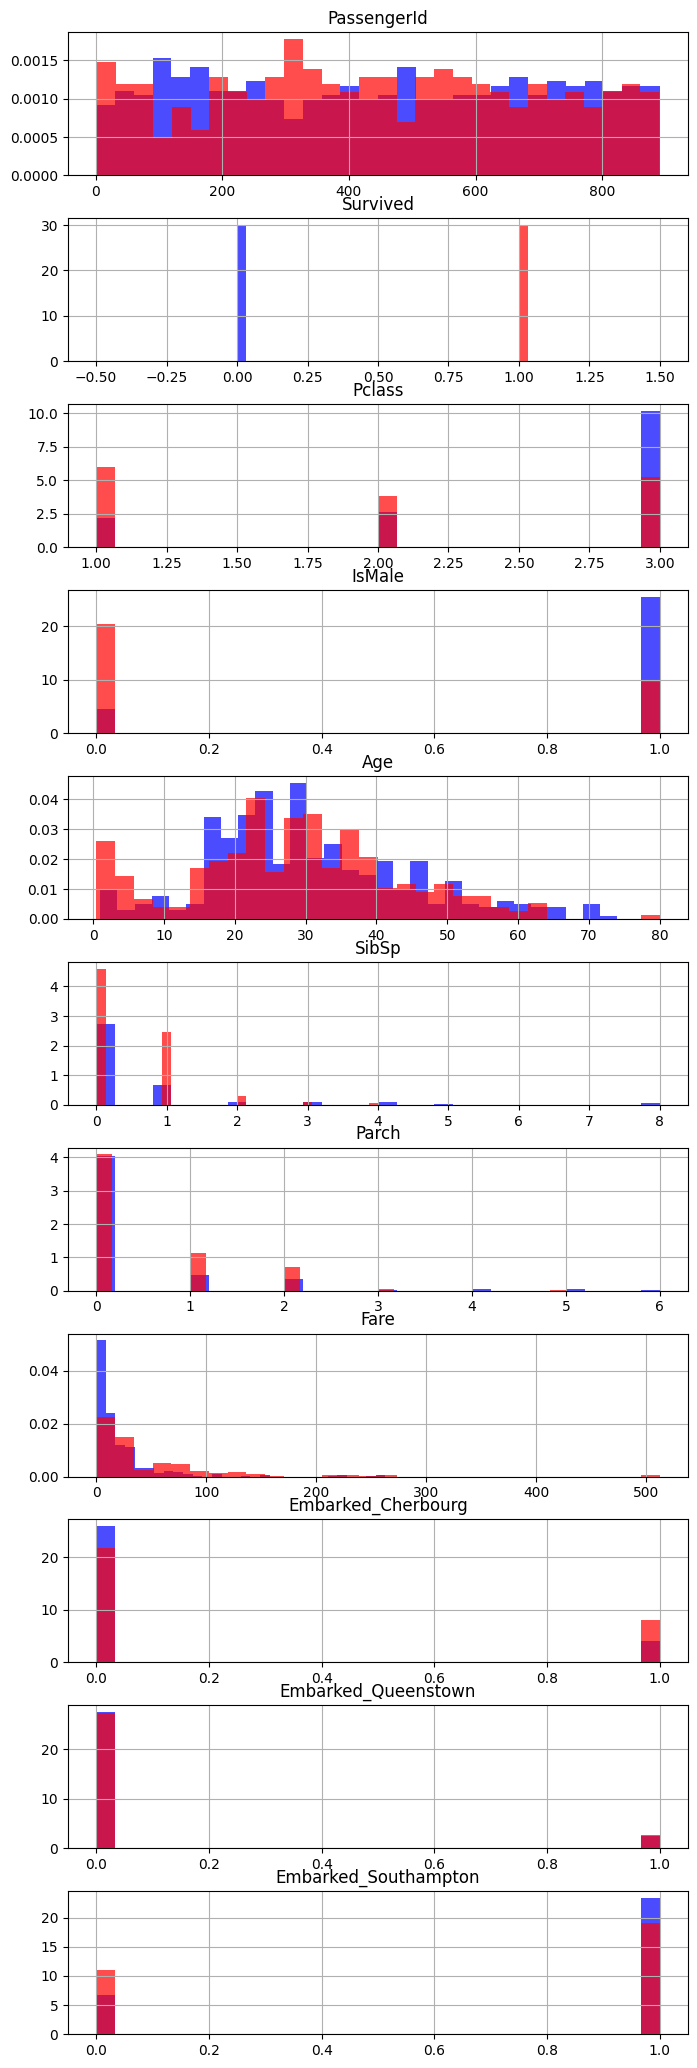

In [37]:
fig, axs = plt.subplots(11,1, figsize=(8, 26))

data[data['Survived'] == 0].hist(bins=30, color='blue', alpha=0.7, density=True, ax=axs)
data[data['Survived'] == 1].hist(bins=30, color='red', alpha=0.7, density=True, ax=axs)

### Look at survival by different groupings

By using the pandas groupby method along with functions like `mean`, we can start to explore the % of people in different categories who survived. 

Let's first quickly remind ourselves of what the 'survived' column looks like.

In [38]:
data['Survived']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

As it's a series of 1's and 0's, taking the mean (adding up the values and dividing by the number of values) gives us the proportion of people who survived. 

Let's start by grouping by sex and seeing who survived. 

In [39]:
data.groupby('IsMale')['Survived'].mean()

IsMale
0    0.742038
1    0.188908
Name: Survived, dtype: float64

We can interpret this as 74.2% of women surviving, and 18.8% of men surviving. 

Let's try with a different grouping - does it work where there are multiple categories?

We can try tidying it up a bit too. 

In [40]:
(data.groupby('Pclass')['Survived'].mean()*100).round(2)

Pclass
1    62.96
2    47.28
3    24.24
Name: Survived, dtype: float64

Yes! It does work where there are multiple options within a category.

Let's take it further - by passing in a **list** of columns to group by, we can explore multiple layers of detail.

Let's turn the output into a dataframe while we're at it.

In [41]:
pd.DataFrame(
    data.groupby(['Pclass', 'IsMale'])['Survived'].mean().round(4)
    )

Survived
Pclass IsMale          
1      0         0.9681
       1         0.3689
2      0         0.9211
       1         0.1574
3      0         0.5000
       1         0.1354

For some instances where we think we might have a low number of people belonging to each column and want to check this, we can use the `.describe()` method instead of the `.mean()` and manually pull back the columns we are interested in. 

Here, we can see that very few people were travelling with 3 or more parents or children so we might not place too much stock in the associated chances of survival.

In [42]:
data.groupby('Parch')['Survived'].describe()[['mean','count']].round(4)

,mean,count
Parch,,
0,0.3437,678.0
1,0.5508,118.0
2,0.5000,80.0
3,0.6000,5.0
4,0.0000,4.0
5,0.2000,5.0
6,0.0000,1.0


For numeric columns, we can create a new grouping ourselves to investigate the differences.

In [43]:
under_18 = np.where(data['Age'] < 18 , 'Under 18', 'Over 18')
data.groupby(under_18)['Survived'].mean()

Over 18     0.361183
Under 18    0.539823
Name: Survived, dtype: float64

In [44]:
under_30 = np.where(data['Age'] < 30 , 'Under 30', 'Over 30')
data.groupby(under_30)['Survived'].mean()

Over 30     0.366864
Under 30    0.406250
Name: Survived, dtype: float64

We can use this new grouping together with a column from our dataframe. 

In [45]:
data.groupby([under_18, 'IsMale'])['Survived'].mean()

          IsMale
Over 18   0         0.752896
          1         0.165703
Under 18  0         0.690909
          1         0.396552
Name: Survived, dtype: float64

In [46]:
over_60 = np.where(data['Age'] >60 , 'Over 60', 'Under 60')
data.groupby([over_60, 'Pclass'])['Survived'].mean()

          Pclass
Over 60   1         0.214286
          2         0.333333
          3         0.200000
Under 60  1         0.658416
          2         0.475138
          3         0.242798
Name: Survived, dtype: float64

In some cases, we may want to assign the results of that column back to our dataframe to use as a new bit of data. 
Let's do that with a column that tells us whether someone is travelling with family.

In [47]:
data['TravellingWithFamily'] = np.where((data['SibSp'] + data['Parch']) >= 1 , 'Travelling with Family', 'Travelling Alone')
data.groupby('TravellingWithFamily')['Survived'].mean()

TravellingWithFamily
Travelling Alone          0.303538
Travelling with Family    0.505650
Name: Survived, dtype: float64

In [48]:
data.groupby(['IsMale', 'TravellingWithFamily'])['Survived'].mean()

IsMale  TravellingWithFamily  
0       Travelling Alone          0.785714
        Travelling with Family    0.712766
1       Travelling Alone          0.155718
        Travelling with Family    0.271084
Name: Survived, dtype: float64

In [49]:
data.groupby(['Pclass', 'TravellingWithFamily'])['Survived'].mean()

Pclass  TravellingWithFamily  
1       Travelling Alone          0.532110
        Travelling with Family    0.728972
2       Travelling Alone          0.346154
        Travelling with Family    0.637500
3       Travelling Alone          0.212963
        Travelling with Family    0.299401
Name: Survived, dtype: float64

# Investigate the individual predictive power of columns

## Correlation

We can create a correlation matrix to look at associations between different columns and also between the column of interest (survived) and each column.

The diagonal shows a column's correlation with itself, which will always be 1!

Red squares indicate a strong positive correlation between features - as one increases, the other increases.

Blue squares indicate a strong negative correlation - as one increases, the other decreases. 

Paler squares indicate less strong correlations. 

We use the `seaborn` (sns) library here instead of `matplotlib` (plt) as it has a really nice built-in correlation plot. 

<Axes: >

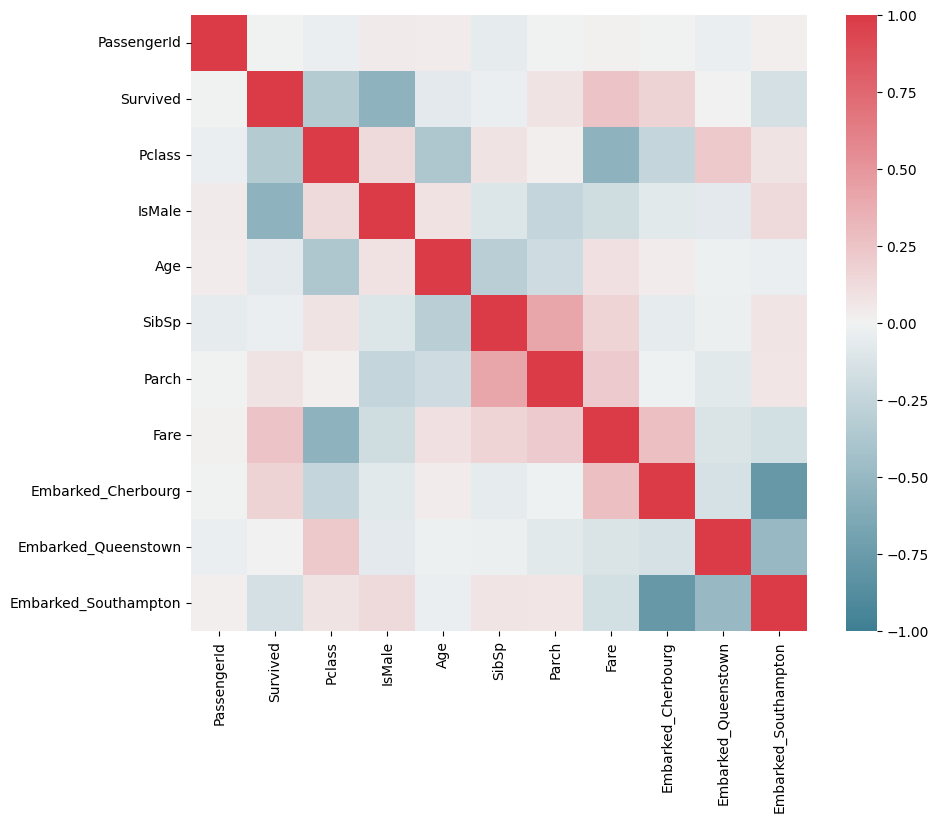

In [50]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.select_dtypes(['number']) .corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

## Predictive Power

An interesting alternative to pure correlations may be the predictive power score. 

However, this doesn't work with pandas versions >2, which we have in our environment, so we won't cover this today.

However, if you are interested, take a look at the repository: https://github.com/8080labs/ppscore

# Further Data Preparation

## Tidying up Column Names

If we don't find the column names of a provided dataset very intuitive, we can tidy these up ourselves.

Let's first remind ourselves of the names we have.

In [51]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'IsMale', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked_Cherbourg',
       'Embarked_Queenstown', 'Embarked_Southampton', 'TravellingWithFamily'],
      dtype='object')

In [52]:
data = data.rename(columns={
            'Parch': 'ParentsOrChildren',
            'SibSp': 'SiblingsOrSpouses',
            'Pclass': 'PClass'
            }
    )

data

,PassengerId,Survived,PClass,Name,IsMale,Age,SiblingsOrSpouses,ParentsOrChildren,Ticket,Fare,Cabin,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,TravellingWithFamily
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,Travelling with Family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1,0,0,Travelling with Family
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,Travelling Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0,0,1,Travelling with Family
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0,0,1,Travelling Alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,0,0,1,Travelling Alone
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,0,0,1,Travelling Alone
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,NaN,0,0,1,Travelling with Family
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,1,0,0,Travelling Alone


## Getting rid of columns we won't use and setting the datatype

We can drop 'Name', 'Ticket', 'Cabin' and 'TravellingWithFamily' here - though look at the `feature_engineering` notebook for how we could make better use of each of these!

For now, we're just trying to create something that is similar - though slightly nicer to work with - than the processed dataset we've used.

In [53]:
data = data.drop(columns=['Name', 'Ticket', 'Cabin', 'TravellingWithFamily'])
data.head()

,PassengerId,Survived,PClass,IsMale,Age,SiblingsOrSpouses,ParentsOrChildren,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,3,1,22.0,1,0,7.2500,0,0,1
1,2,1,1,0,38.0,1,0,71.2833,1,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,1
3,4,1,1,0,35.0,1,0,53.1000,0,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,0,1


All of our columns here are integers or floats so can be dealt with by the models. 

If they were not, we could use

`data = data.astype('float')`

# SUMMARY - Start to Finish Prep of This Dataset

For easy reference, here is a start to finish cell showing preparation of this dataset for use with a machine learning algorithm.

In [54]:
###############
# Import data #
###############
data = pd.read_csv("data/raw_data.csv")

###############################
# Replace unclear data values #
###############################
embarked_lookup = {
    'S': 'Southampton',
    'C':  'Cherbourg',
    'Q': 'Queenstown'
}

data['Embarked'] = data['Embarked'].apply(lambda row_value: embarked_lookup.get(row_value))

#######################
# One hot encoding    #
#######################
one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked').astype('int')
# Drop the column as it is now encoded
data = data.drop('Embarked', axis = 1)
# Join the encoded df
data = data.join(one_hot)

#######################
# Dichotomous columns #
#######################
data['Sex'].replace('male', 1, inplace=True)
data['Sex'].replace('female', 0, inplace=True)
data = data.rename(columns={'Sex': 'IsMale'})

#####################################
# Tidying up remaining column names #
#####################################
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])

data.head()

,PassengerId,Survived,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,1,0,3,1,22.0,1,0,7.2500,0,0,1
1,2,1,1,0,38.0,1,0,71.2833,1,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,1
3,4,1,1,0,35.0,1,0,53.1000,0,0,1
4,5,0,3,1,35.0,0,0,8.0500,0,0,1


We can then demonstrate its use with a classifier.

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

X = data.drop(columns='Survived')
y = data['Survived']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
    )

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)

pd.DataFrame(
    classification_report(y_val, y_val_pred, output_dict=True)
)

,0,1,accuracy,macro avg,weighted avg
precision,0.83908,0.75,0.804196,0.79454,0.804196
recall,0.83908,0.75,0.804196,0.79454,0.804196
f1-score,0.83908,0.75,0.804196,0.79454,0.804196
support,87.00000,56.00,0.804196,143.00000,143.000000


## A quick note on scaling and imputation

Depending on the type of model we choose to use, we may need to scale the data *and/or* we may need to manually deal with missing data.

Generally we don't need to do these steps for tree-based models. 

First, let's deal with the missing data. Here, we are just using a simple imputation method, but the options are discussed in more depth in the relevant notebook.

There are some debates about whether to impute first or standardise first.

In [56]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

X_train = imp_mean.fit_transform(X_train)
X_val = imp_mean.fit_transform(X_val)


Now let's scale the data - as mentioned, this isn't necessary for tree-based algorithms.

For other non-tree algorithms (that aren't deep learning), we tend to use **standardisation**. 

For deep learning models, we tend to use **normalisation**, which can be applied very similarly to the below. 

In [57]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

# Apply the scaler to the training and test sets
X_train_standardised = sc.fit_transform(X_train)
X_val_standardised = sc.fit_transform(X_val)
X_test_standardised = sc.fit_transform(X_test)

Finally we can fit a model to our standardised data - here, we're going to use a logistic regression - and explore its performance.

In [58]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_standardised, y_train)

y_val_pred = model.predict(X_val_standardised)

pd.DataFrame(
    classification_report(y_val, y_val_pred, output_dict=True)
)

,0,1,accuracy,macro avg,weighted avg
precision,0.842697,0.777778,0.818182,0.810237,0.817274
recall,0.862069,0.750000,0.818182,0.806034,0.818182
f1-score,0.852273,0.763636,0.818182,0.807955,0.817562
support,87.000000,56.000000,0.818182,143.000000,143.000000


We could then undertake further hyperparameter optimisation, feature selection and feature engineering, testing all of this with our validation dataset, before doing a final test of our resulting model on the test dataset we created.